## Members 
- Benedictus Kent RACHMAT
- Dana AUBAKIROVA
- Diego Andres TORRES GUARIN

## Exploratory data analysis

Import the necessary libraries

In [30]:
import os
import csv
import torch
import sklearn
import platform
import colorsys
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from PIL import ImageStat
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from torchvision import datasets, transforms

In [31]:
if platform.system() == "Darwin":
    %config InlineBackend.figure_format="retina"  # For high DPI display

print(sklearn.__version__)  # Version tested on sklearn.__version__ == 1.0.1

%load_ext autoreload
%autoreload 2

1.0.2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
dotenv_path = Path('../public.env')
load_dotenv(dotenv_path=dotenv_path)

PUBLIC_DATA = os.getenv('PUBLIC_DATA')
SAMPLE_DATA = os.getenv('SAMPLE_DATA')
NEW_DATA    = os.getenv('NEW_DATA')

DATA_PATH = Path(PUBLIC_DATA)

DATA_NAME = "Areal"

DATA_SETS = ["train", "valid", "test"]
ALL_SETS = ["train", "valid-lab", "valid", "test"]

TORCH_MODEL = Path("torch/model")

Import the image using `datasets.ImageFolder` (Assuming that we have the data with image format by running the file `data/prepare_dataset.py`)

In [33]:
train_folder = datasets.ImageFolder(NEW_DATA+'/train', transform=None)
train_data   = list(train_folder)

val_folder = datasets.ImageFolder(NEW_DATA+'/valid-lab', transform=None)
val_data   = list(val_folder)

shape_example = np.array(train_data[0][0])

print("Number of datapoints for training data:",len(train_data))
print("Number of datapoints for validation data:",len(val_data))
print("Shape of the image:", shape_example.shape)

Number of datapoints for training data: 4160
Number of datapoints for validation data: 1040
Shape of the image: (128, 128, 3)


Using the `train_folder` variable, we can extract the class names

In [34]:
idx_to_class_train = {v:k for k, v in train_folder.class_to_idx.items()}
classes_train      = [idx_to_class_train[x] for x in train_folder.targets]

idx_to_class_val = {v:k for k, v in val_folder.class_to_idx.items()}
classes_val      = [idx_to_class_val[x] for x in val_folder.targets]

df_label = pd.DataFrame(list(train_folder.class_to_idx.items()),columns = ['labels', 'code'])
print(df_label.to_string(index=False))

   labels  code
    beach     0
chaparral     1
    cloud     2
   desert     3
   forest     4
   island     5
     lake     6
   meadow     7
 mountain     8
    river     9
      sea    10
 snowberg    11
  wetland    12


Using `pandas` we could plot how many pictures we have for each label, we can conclude that chaparral has the most data among all.

In [35]:
class_counts = pd.Series(classes_train).value_counts()
class_counts_val = pd.Series(classes_val).value_counts()
concat_classes = pd.concat([class_counts, class_counts_val], axis=1, keys=["train","validation"])
concat_classes

,train,validation
chaparral,330,70
desert,327,73
wetland,324,76
lake,322,78
snowberg,322,78
meadow,320,80
river,320,80
forest,319,81
island,319,81
sea,319,81


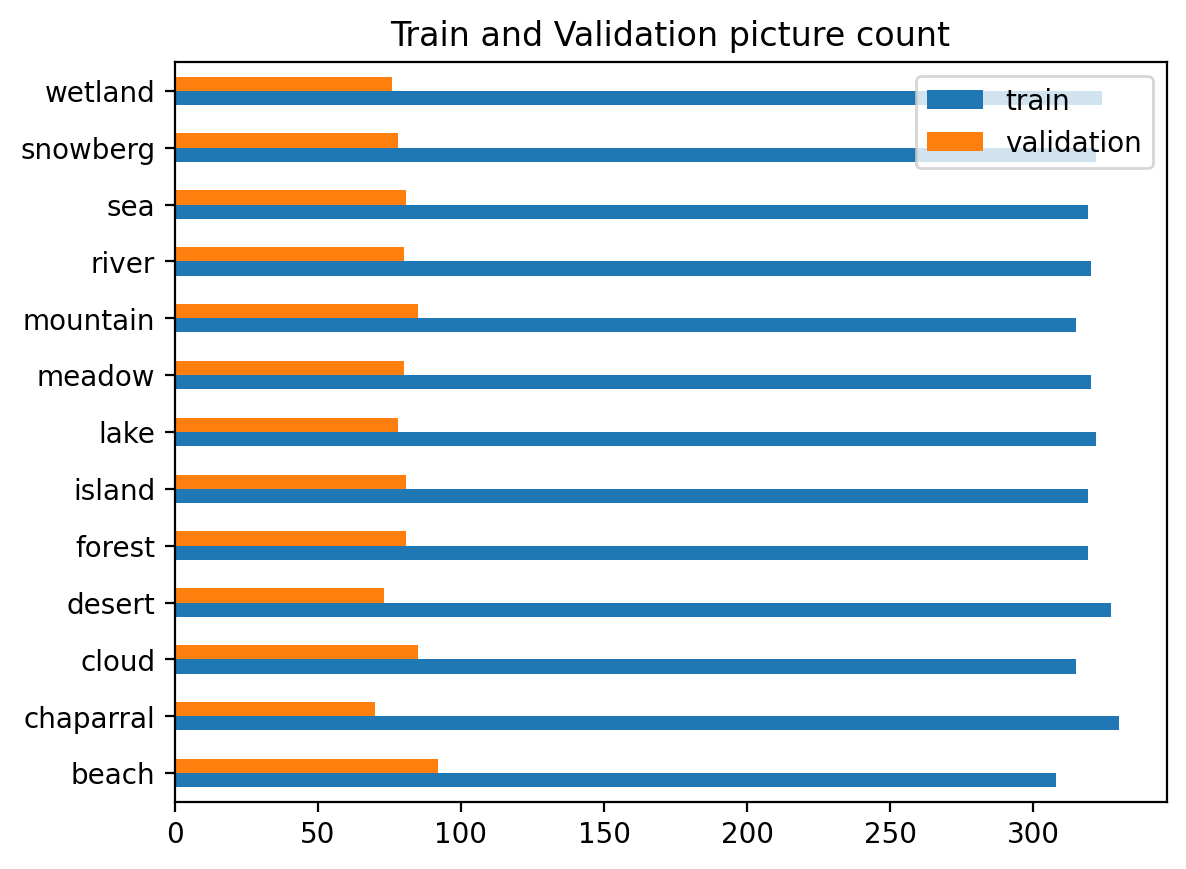

In [36]:
df = pd.DataFrame({'train': class_counts,
                   'validation': class_counts_val})
ax = df.plot.barh()
ax.set(title="Train and Validation picture count")
plt.show()

We could also calculate the probability distribution of each label 

In [37]:
training_prob = class_counts/class_counts.sum()
validation_prob = class_counts_val/class_counts_val.sum()
concat_prob = pd.concat([training_prob, validation_prob], axis=1, keys=["train","validation"])
concat_prob

,train,validation
chaparral,0.079327,0.067308
desert,0.078606,0.070192
wetland,0.077885,0.073077
lake,0.077404,0.075000
snowberg,0.077404,0.075000
meadow,0.076923,0.076923
river,0.076923,0.076923
forest,0.076683,0.077885
island,0.076683,0.077885
sea,0.076683,0.077885


In [38]:
def give_figure(label):
    ROWS, COLS = 4,4
    indices = np.random.choice(np.where(np.array(classes_train)==label)[0], ROWS*COLS)
    fig, axes = plt.subplots(ROWS, COLS, figsize=(20,20))
    for ax, idx in zip(axes.flatten(), indices):
        img = train_data[idx][0]
        ax.imshow(np.array(img))
        
    return fig

To see the images, we could change the parameter `label` to whatever label we want to see some of the images

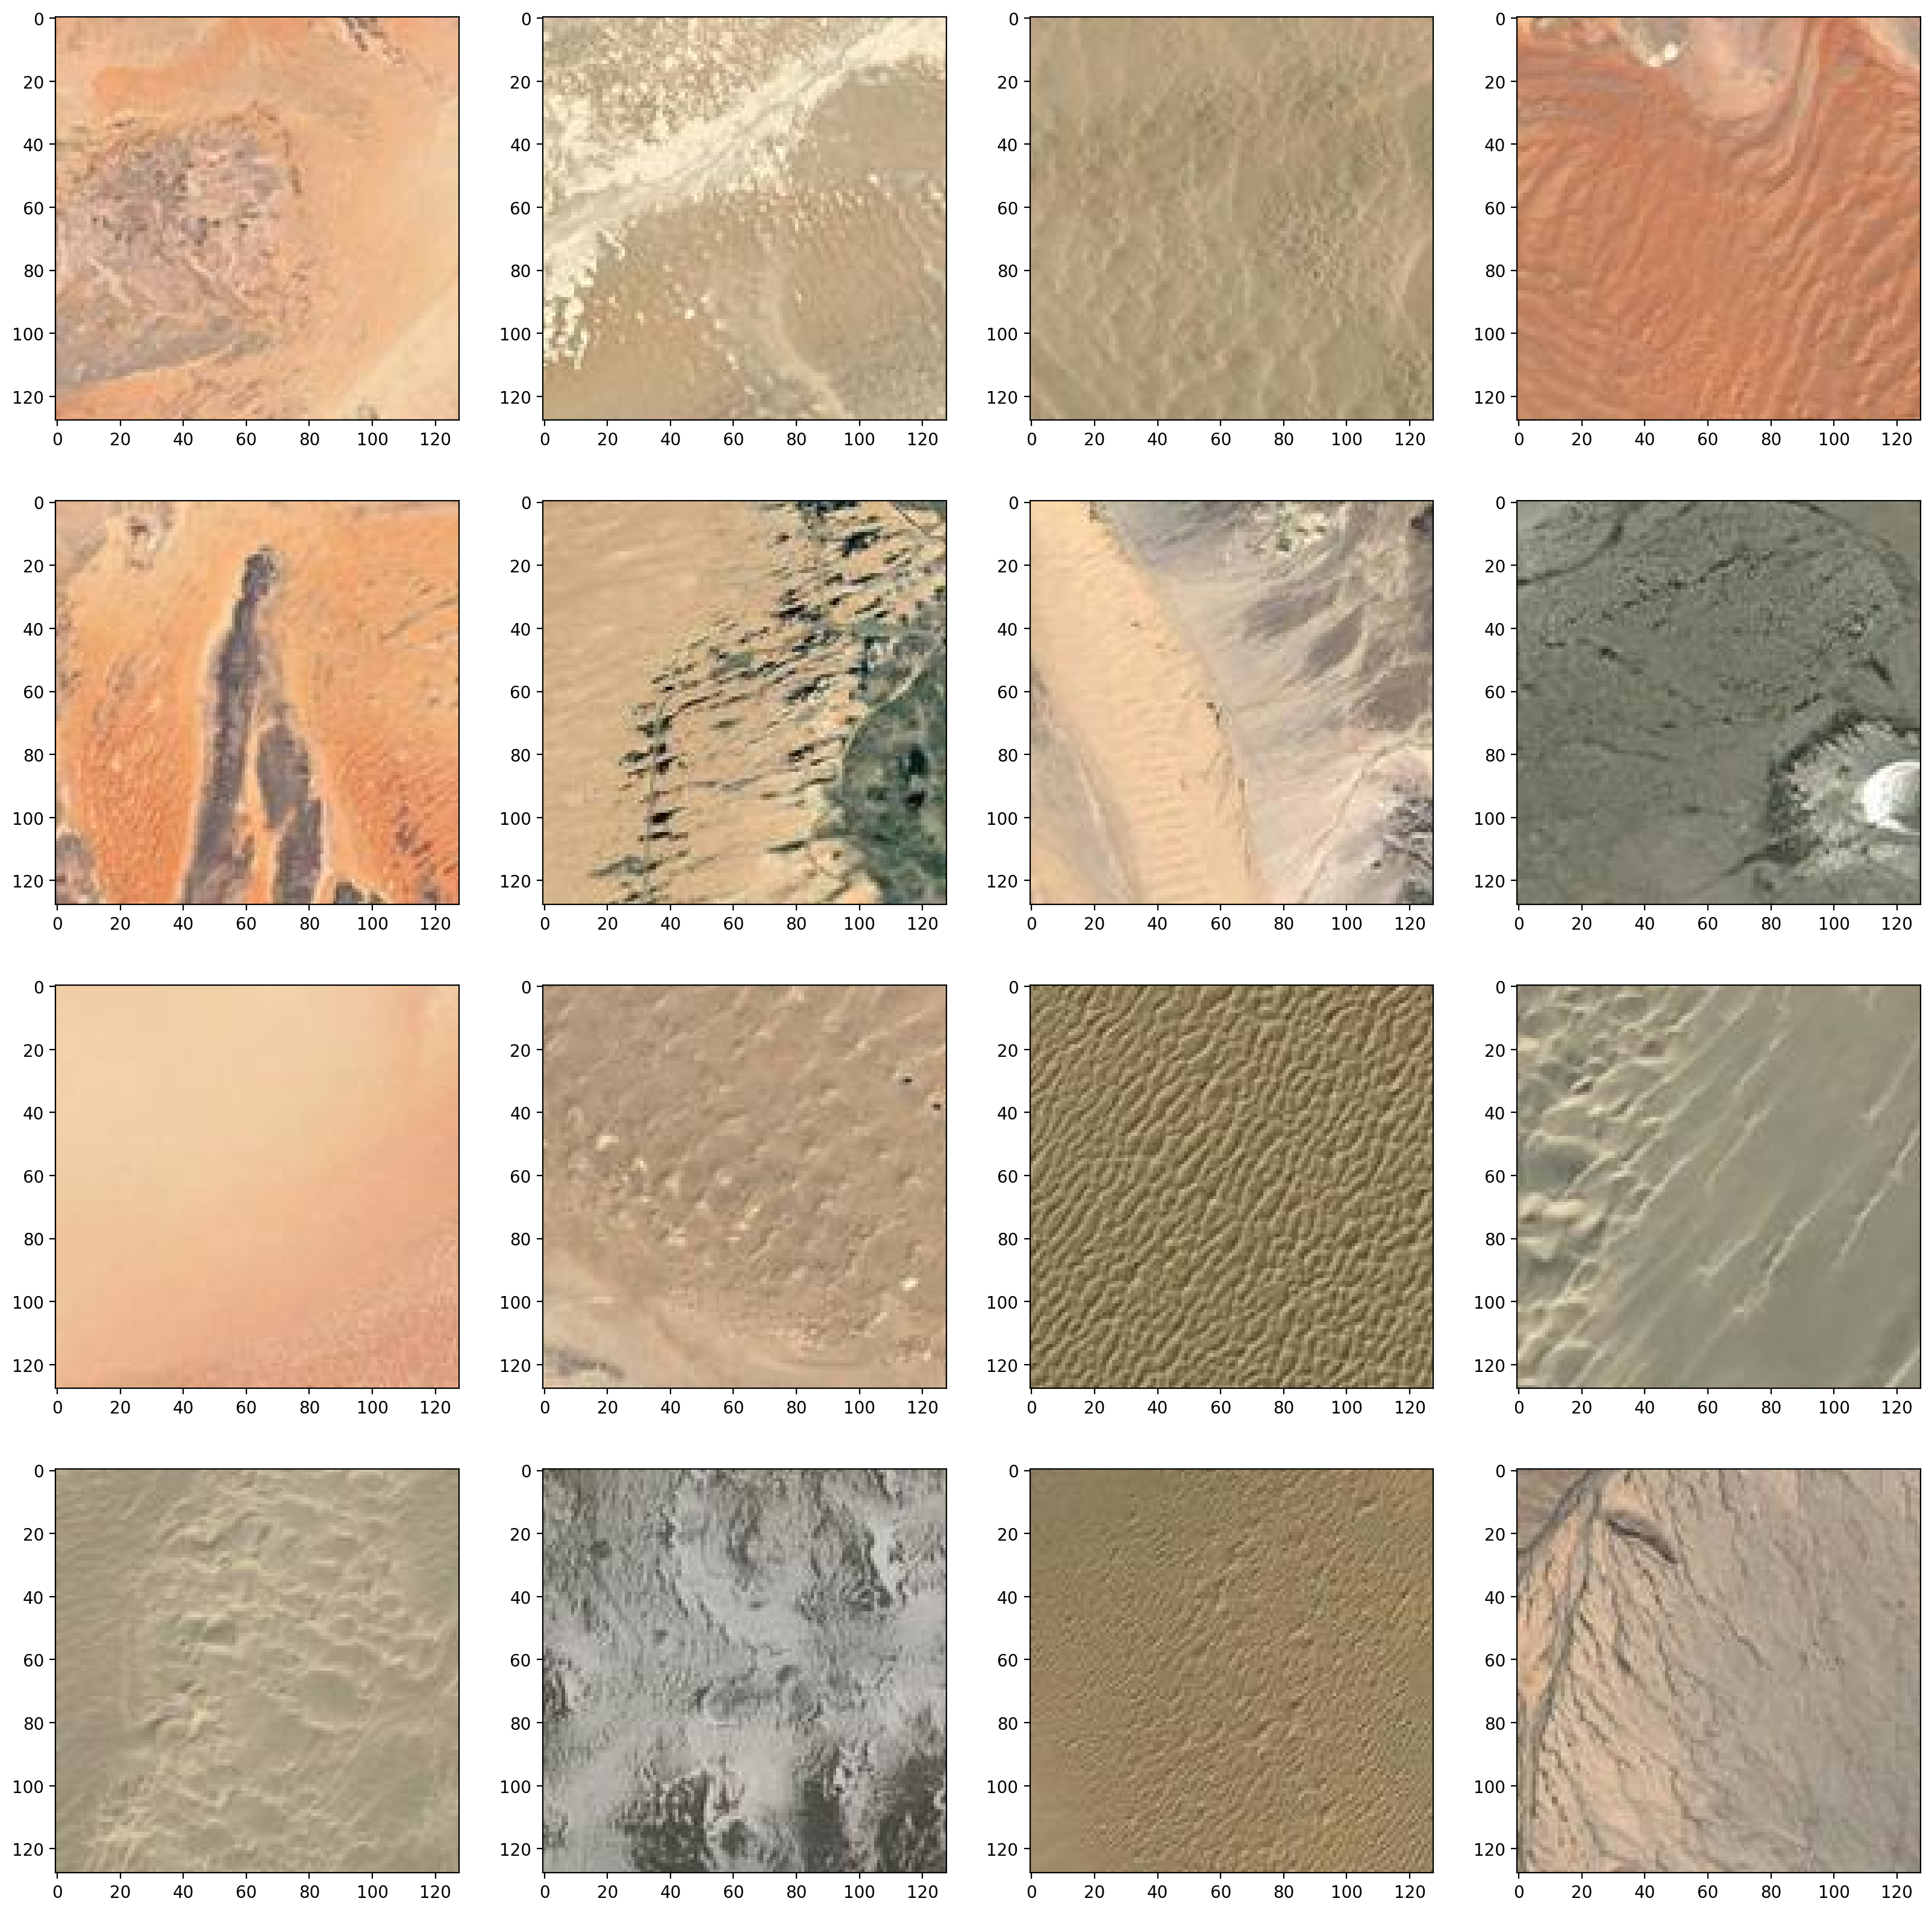

In [ ]:
give_figure('desert')

For further exploratory data analysis, we could analyze the RGB color model and plot the graph 

In [ ]:
data_coords_train = pd.DataFrame(np.zeros((len(train_data), 4)), columns=list('RGB')+['label'])
for n, (img, label) in enumerate(train_data):
    data_coords_train.iloc[n, :3] = np.array(img).mean(axis=(0,1))
    data_coords_train.iloc[n, 3] = idx_to_class_train[label]
    
data_coords_train

In [ ]:
data_coords_val = pd.DataFrame(np.zeros((len(val_data), 4)), columns=list('RGB')+['label'])
for n, (img, label) in enumerate(val_data):
    data_coords_val.iloc[n, :3] = np.array(img).mean(axis=(0,1))
    data_coords_val.iloc[n, 3] = idx_to_class_val[label]
    
data_coords_val

In [ ]:
pca = PCA(2)
data_coords_train[list('RGB')] = data_coords_train[list('RGB')]/255
data_coords_val[list('RGB')] = data_coords_val[list('RGB')]/255

transformed_coords_train = pca.fit_transform(data_coords_train[list('RGB')])
transformed_coords_val = pca.fit_transform(data_coords_val[list('RGB')])

data_coords_train[list('xy')] = transformed_coords_train
data_coords_val[list('xy')] = transformed_coords_val

red, green, blue = pca.transform(np.identity(3)) 

In [ ]:
# training data
plt.figure(figsize=(10,10))
sns.scatterplot(x='x', y='y', hue='label', data=data_coords_train, palette='tab20')
plt.arrow(0,0,*blue, color='blue', label='blue')
plt.arrow(0,0,*green, color='green', label='green')
plt.arrow(0,0,*red, color='red', label='red')
plt.title("RGB distribution for training data")
plt.legend()
plt.show()

In [ ]:
# validation data
plt.figure(figsize=(10,10))
sns.scatterplot(x='x', y='y', hue='label', data=data_coords_val, palette='tab20')
plt.arrow(0,0,*blue, color='blue', label='blue')
plt.arrow(0,0,*green, color='green', label='green')
plt.arrow(0,0,*red, color='red', label='red')
plt.title("RGB distribution for validation data")
plt.legend()
plt.show()

In [ ]:
def brightness(dt, cls):
    avg_classes = dict()
    for labels in df_label['labels']:
        avg = 0
        for mat in np.where(np.array(cls)==labels)[0]:
            im   = dt[mat][0].convert('L')
            stat = ImageStat.Stat(im)
            m    = stat.mean[0]
            avg += m

        avg_classes[labels] = avg/len(np.where(np.array(cls)==labels)[0])
    return avg_classes

brightness_train = brightness(train_data, classes_train)
brightness_val   = brightness(val_data, classes_val)

pd_brightness_train = pd.Series(brightness_train)
pd_brightness_val   = pd.Series(brightness_val)

In [ ]:
df = pd.DataFrame({'train': pd_brightness_train,
                   'validation': pd_brightness_val})
ax = df.plot.barh()
plt.title("Plot of the brightness level")
plt.show()

In [17]:
huv_train = pd.DataFrame(np.zeros((len(train_data), 4)), columns=list('HSV')+['label'])

for n, (img, label) in enumerate(train_data):
    (r, g, b) = np.array(img).mean(axis=(0,1))
    huv_train.iloc[n, :3] = colorsys.rgb_to_hsv(r, g, b)
    huv_train.iloc[n, 3]  = idx_to_class_train[label]
    
huv_val = pd.DataFrame(np.zeros((len(val_data), 4)), columns=list('HSV')+['label'])

for n, (img, label) in enumerate(val_data):
    (r, g, b) = np.array(img).mean(axis=(0,1))
    huv_val.iloc[n, :3] = colorsys.rgb_to_hsv(r, g, b)
    huv_val.iloc[n, 3]  = idx_to_class_val[label]

NameError: name 'idx_to_class' is not defined

In [ ]:
huv_train

In [ ]:
huv_val

In [ ]:
# plt.figure(figsize=(10,10))
# sns.scatterplot(x='x', y='y', hue='label', data=data_coords1, palette='tab20')
# plt.arrow(0,0,*blue, color='blue', label='blue')
# plt.arrow(0,0,*green, color='green', label='green')
# plt.arrow(0,0,*red, color='red', label='red')
# plt.legend()
# plt.show()